# Introduction

**[AutoRA](https://pypi.org/project/autora/)** (**Au**tomated **R**esearch **A**ssistant) is an open-source framework designed to automate various stages of empirical research, including model discovery, experimental design, and data collection.

This notebook is the fourth of four notebooks within the basic tutorials of ``autora``. We suggest that you go through these notebooks in order as each builds upon the last. However, each notebook is self-contained and so there is no need to *run* the content of the last notebook for your current notebook. We will here provide a link to each notebook, but we will also provide a link at the end of each notebook to navigate you to the next notebook.

[AutoRA Basic Tutorial I: Components](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-I-Components/) <br>
[AutoRA Basic Tutorial II: Loop Constructs](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-II-Loop-Constructs/) <br>
[AutoRA Basic Tutorial III: Functional Workflow](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-III-Functional-Workflow/) <br>
[AutoRA Basic Tutorial IV: Customization](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-IV-Customization/) <br>

These notebooks provide a comprehensive introduction to the capabilities of ``autora``. **It demonstrates the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments.**

**How to use this notebook** *You can progress through the notebook section by section or directly navigate to specific sections. If you choose the latter, it is recommended to execute all cells in the notebook initially, allowing you to easily rerun the cells in each section later without issues.*

## Tutorial Setup

We will here import some standard python packages, set seeds for replicability, and define a plotting function.

In [ ]:
#### Installation ####
!pip install -q "autora[theorist-bms]"

#### Import modules ####
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import torch

from autora.variable import Variable, ValueType, VariableCollection
from autora.state import StandardState, on_state, estimator_on_state
from autora.experimentalist.random import random_pool
from autora.theorist.bms import BMSRegressor
from autora.experiment_runner.synthetic.abstract.equation import equation_experiment

#### Set seeds ####
np.random.seed(42)
torch.manual_seed(42)

#### Define plot function ####
def plot_from_state(s: StandardState, expr: str):    
    
    """
    Plots the data, the ground truth model, and the current predicted model
    """
    
    #Determine labels and variables
    model_label = f"Model: {s.model.repr()}" if hasattr(s.model,'.repr') else "Model"
    experiment_data = s.experiment_data.sort_values(by=["x"])
    ground_x = np.linspace(s.variables.independent_variables[0].value_range[0],s.variables.independent_variables[0].value_range[1],100)
    
    #Determine predicted ground truth
    equation = sp.simplify(expr)
    ground_predicted_y = [equation.evalf(subs={'x':x}) for x in ground_x]
    model_predicted_y = s.model.predict(ground_x.reshape(-1, 1))

    #Plot the data and models
    f = plt.figure(figsize=(4,3))
    plt.plot(experiment_data["x"], experiment_data["y"], 'o', label = None)
    plt.plot(ground_x, model_predicted_y, alpha=.8, label=model_label)
    plt.plot(ground_x, ground_predicted_y, alpha=.8,  label=f'Ground Truth: {expr}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Customizing Automated Empirical Research Components

``autora`` is a flexible framework in which users can integrate their own experimentalists, experiment runners, and theorists in an automated empirical research workflow. This section illustrates the integration of custom `autora` components. For more information on how to contribute your own modules to the ``autora`` ecosystem, please refer to the [Contributor Documentation](https://autoresearch.github.io/autora/contribute/modules/).

To illustrate the use of custom experimentalists, experiment runners, and theorists, we consider a simple workflow:
1. Generate 10 seed experimental conditions using `random_pool`
2. Iterate through the following steps
   - Identify 3 new experimental conditions using an ``experimentalist``
   - Collect observations using the ``experiment_runner``
   - Identify a model relating conditions to observations using a ``theorist``

Once this workflow is setup, we will replace each component with a custom function.

In [ ]:
#### Define metadata ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

#### Define condition pool ####
conditions = random_pool(variables, num_samples=10, random_state=0)

#### Define state ####
s = StandardState(
    variables = variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=["x","y"])
)

#### Define experimentalist and wrap with state functionality ####
experimentalist = on_state(random_pool, output=["conditions"])

#### Define experiment runner and wrap with state functionality ####
sin_experiment = equation_experiment(sp.simplify('sin(x)'), variables.independent_variables, variables.dependent_variables[0])
sin_runner = sin_experiment.experiment_runner

experiment_runner = on_state(sin_runner, output=["experiment_data"])

#### Define theorist and wrap with state functionality ####
theorist = estimator_on_state(BMSRegressor(epochs=100))

We should quickly test to make sure everything works as expected.

INFO:autora.theorist.bms.regressor:BMS fitting started


Previous State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  5.416539
1  4.116570
2  3.249923
3  1.733292
4  1.949954
5  0.216662
6  0.433323
7  0.000000
8  1.083308
9  5.199877, experiment_data=Emp

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


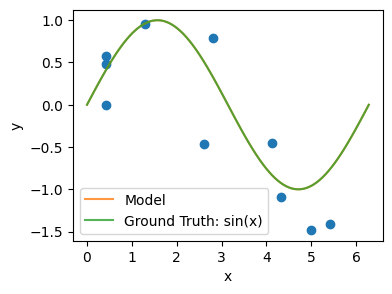

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:04<00:00, 21.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


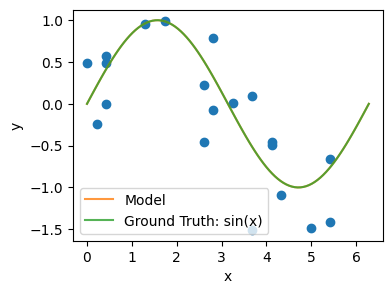


Updated State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  3.249923
1  4.116570
2  2.599939
3  0.216662
4  3.683247
5  0.000000
6  1.733292
7  5.416539
8  2.816600
9  3.683247, experiment_data=   

In [ ]:
print('\033[1mPrevious State:\033[0m')
print(s)

for cycle in range(2):
    s = experimentalist(s, num_samples=10, random_state=42+cycle)
    s = experiment_runner(s, added_noise=0.5, random_state=42+cycle)
    s = theorist(s)
    
    plot_from_state(s, 'sin(x)')

print('\n\033[1mUpdated State:\033[0m')
print(s)

## Custom Experimentalists

Experimentalists must be implemented as functions. For instance, an experimentalist sampler function expects a pool of experimental conditions and returns a modified set of experimental conditions. 

**Requirements for working with the state:**
- The function has a `variables` argument that accepts the `VariableCollection` type
- The function has a `conditions` argument that accepts a `pandas.DataFrame`
- The function returns a `pandas.DataFrame`

The custom `uniform_sampler` below will select conditions that are the least represented in the data. 

*Note that when building custom experimentalists, we can either wrap the function with `on_state(output=['conditions'])` as we did in tutorial III, or else we can use the `@on_state(output=['conditions'])` decorator.*

In [ ]:
#==================================================================#
#                 Option 1 - Wrapping our Component                #
#==================================================================#

def uniform_sample(variables: VariableCollection, conditions: pd.DataFrame, num_samples: int = 1, random_state: Optional [int] = None):

    """
    An experimentalist that selects the least represented datapoints
    """
    #Set rng seed
    rng = np.random.default_rng(random_state)

    #Retrieve the possible values
    allowed_values = variables.independent_variables[0].allowed_values
    
    #Determine the representation of each value
    conditions_count = np.array([conditions["x"].isin([value]).sum(axis=0) for value in allowed_values])
    
    #Sort to determine the least represented values
    conditions_sort = conditions_count.argsort()
    
    conditions_count = conditions_count[conditions_sort]
    values_count = allowed_values[conditions_sort]
    
    #Sample from values with the smallest frequency
    x = values_count[conditions_count<=conditions_count[num_samples-1]]
    x = rng.choice(x,num_samples)
    
    return pd.DataFrame({"x": x})

custom_experimentalist = on_state(uniform_sample, output=["conditions"])

#==================================================================#
#                   Option 2 - Using a Decorator                   #
#==================================================================#

@on_state(output=["conditions"])
def custom_experimentalist(variables: VariableCollection, conditions: pd.DataFrame, num_samples: int = 1, random_state: Optional [int] = None):

    """
    An experimentalist that selects the least represented datapoints
    """
    #Set rng seed
    rng = np.random.default_rng(random_state)

    #Retrieve the possible values
    allowed_values = variables.independent_variables[0].allowed_values
    
    #Determine the representation of each value
    conditions_count = np.array([conditions["x"].isin([value]).sum(axis=0) for value in allowed_values])
    
    #Sort to determine the least represented values
    conditions_sort = conditions_count.argsort()
    
    conditions_count = conditions_count[conditions_sort]
    values_count = allowed_values[conditions_sort]
    
    #Sample from values with the smallest frequency
    x = values_count[conditions_count<=conditions_count[num_samples-1]]
    x = rng.choice(x,num_samples)
    
    return pd.DataFrame({"x": x})

Now, we will re-run our initial workflow while incorporating our custom experimentalist.

INFO:autora.theorist.bms.regressor:BMS fitting started


Previous State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  5.416539
1  4.116570
2  3.249923
3  1.733292
4  1.949954
5  0.216662
6  0.433323
7  0.000000
8  1.083308
9  5.199877, experiment_data=Emp

100%|██████████| 100/100 [00:05<00:00, 18.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


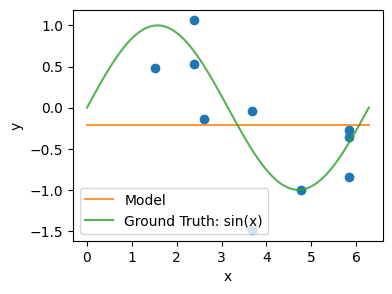

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:04<00:00, 20.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


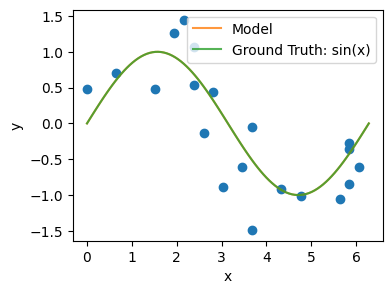

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:03<00:00, 28.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


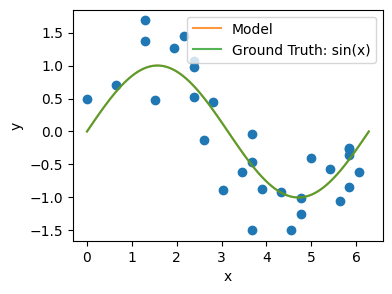

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:03<00:00, 26.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


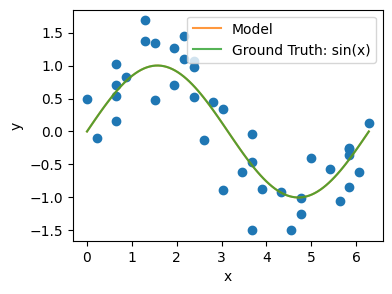

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:04<00:00, 24.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


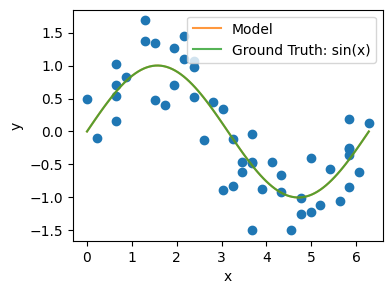


Updated State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  4.983216
1  5.849862
2  3.466585
3  4.116570
4  1.733292
5  3.249923
6  3.249923
7  5.199877
8  3.683247
9  4.333231, experiment_data=   

In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

conditions = random_pool(variables, num_samples=10, random_state=0)

s = StandardState(variables = variables, conditions = conditions, experiment_data = pd.DataFrame(columns=["x","y"]))

#Report previous state
print('\033[1mPrevious State:\033[0m')
print(s)

#Cycle
for cycle in range(5):
    s = custom_experimentalist(s, num_samples = 10, random_state=42+cycle) #Our custom experimentalist
    s = experiment_runner(s, added_noise=0.5, random_state=42+cycle)
    s = theorist(s)
    
    plot_from_state(s,'sin(x)')

#Report updated state
print('\n\033[1mUpdated State:\033[0m')
print(s)

## Custom Experiment Runner

Experiment runners must be implemented as functions. 

**Requirements for working with the state:**
- The function has a `conditions` argument that accepts a `pandas.DataFrame`
- The function returns a `pandas.DataFrame`

The custom `quadratic_experiment` below will apply a quadratic transform (`x + x**2`) to the conditions.

*Note that when building custom experiment runners, we can either wrap the function with `on_state(output=['experiment_data'])` as we did in tutorial III, or else we can use the `@on_state(output=['experiment_data'])` decorator.*

In [ ]:
#==================================================================#
#                 Option 1 - Wrapping our Component                #
#==================================================================#

def quadratic_experiment(conditions: pd.DataFrame, added_noise: int = 0.01, random_state: Optional[int] = None):
    
    #Set rng seed
    rng = np.random.default_rng(random_state)
    
    #Extract conditions
    x = conditions["x"]
    
    #Compute data
    y = (x + x**2) + rng.normal(0, added_noise, size=x.shape)
    
    #Assign to dataframe
    observations = conditions.assign(y = y)
    
    return observations

custom_experiment_runner = on_state(quadratic_experiment, output=["experiment_data"])

#==================================================================#
#                   Option 2 - Using a Decorator                   #
#==================================================================#

@on_state(output=["experiment_data"])
def quadratic_experiment(conditions: pd.DataFrame, added_noise: int = 0.01, random_state: Optional[int] = None):
    
    #Set rng seed
    rng = np.random.default_rng(random_state)
    
    #Extract conditions
    x = conditions["x"]
    
    #Compute data
    y = (x + x**2) + rng.normal(0, added_noise, size=x.shape)
    
    #Assign to dataframe
    observations = conditions.assign(y = y)
    
    return observations

Now, we will re-run our initial workflow while incorporating our custom experiment runner.

INFO:autora.theorist.bms.regressor:BMS fitting started


Previous State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  5.416539
1  4.116570
2  3.249923
3  1.733292
4  1.949954
5  0.216662
6  0.433323
7  0.000000
8  1.083308
9  5.199877, experiment_data=Emp

100%|██████████| 100/100 [00:06<00:00, 15.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


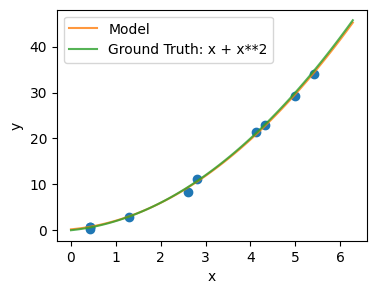

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:06<00:00, 16.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


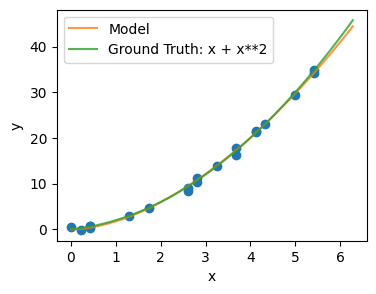

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:04<00:00, 21.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


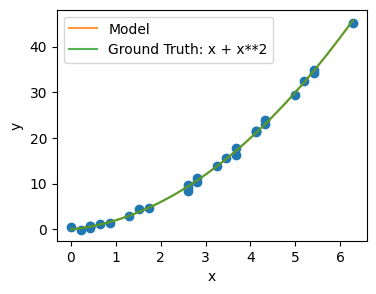

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:05<00:00, 18.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


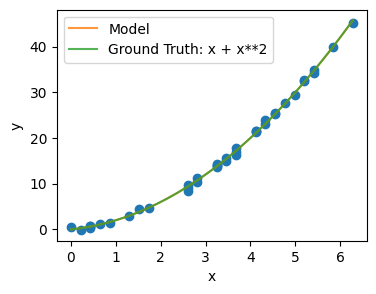

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 100/100 [00:05<00:00, 18.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


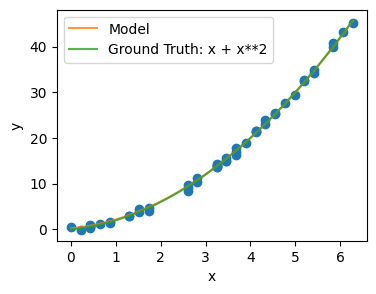


Updated State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  3.249923
1  5.849862
2  1.299969
3  0.433323
4  3.466585
5  1.733292
6  1.516631
7  3.899908
8  0.866646
9  6.066524, experiment_data=   

In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

conditions = random_pool(variables, num_samples=10, random_state=0)

s = StandardState(variables = variables, conditions = conditions, experiment_data = pd.DataFrame(columns=["x","y"]))

#Report previous state
print('\033[1mPrevious State:\033[0m')
print(s)

#Cycle
for cycle in range(5):
    s = experimentalist(s, num_samples = 10, random_state=42+cycle)
    s = custom_experiment_runner(s, added_noise=0.5, random_state=42+cycle)
    s = theorist(s)
    
    plot_from_state(s, 'x + x**2')

#Report updated state
print('\n\033[1mUpdated State:\033[0m')
print(s)

## Custom Theorists

Theorists must be implemented as classes that inherit from  `sklearn.base.BaseEstimator`. The class must implement the following methods:

- `fit(self, conditions, observations)`
- `predict(self, conditions)`

**Requirements for working with the state:**
- The fit module function has a `conditions` argument that accepts a `pandas.DataFrame`
- The fit module function has an `observations` argument that accepts a `pandas.DataFrame`
- the fit function returns `self` (i.e., the model itself)

The custom `PolynomialRegressor` below fits a polynomial of a specified degree.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator

class PolynomialRegressor(BaseEstimator):

    def __init__(self, degree: int = 3):
        self.degree = degree

    def fit(self, conditions: pd.DataFrame, observations: pd.DataFrame):
        c = np.array(conditions)
        o = np.array(observations)

        # polyfit expects a 1D array
        if c.ndim > 1:
            c = c.flatten()

        if o.ndim > 1:
            o = o.flatten()

        # fit polynomial
        self.coeff = np.polyfit(c, o, self.degree)
        self.polynomial = np.poly1d(self.coeff)
        return self

    def predict(self, conditions: pd.DataFrame):
        c = np.array(conditions)
        return self.polynomial(c)
    
custom_theorist = estimator_on_state(PolynomialRegressor())

Now, we will re-run our initial workflow while incorporating our custom theorist.

Previous State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  5.416539
1  4.116570
2  3.249923
3  1.733292
4  1.949954
5  0.216662
6  0.433323
7  0.000000
8  1.083308
9  5.199877, experiment_data=Emp

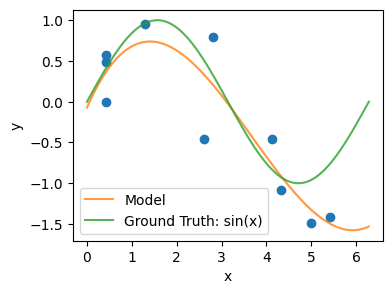

PolynomialRegressor()


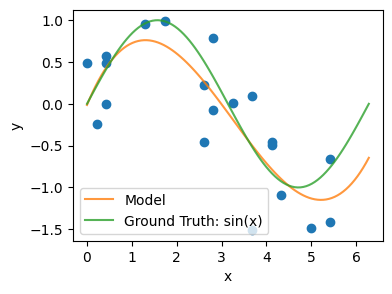

PolynomialRegressor()


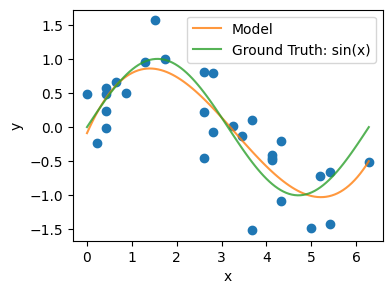

PolynomialRegressor()


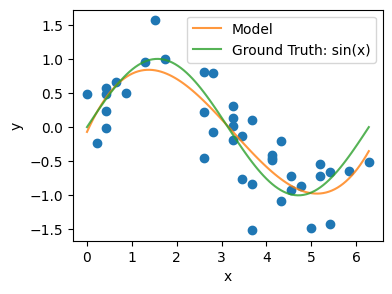

PolynomialRegressor()


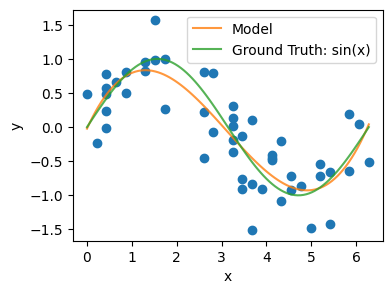


Updated State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  3.249923
1  5.849862
2  1.299969
3  0.433323
4  3.466585
5  1.733292
6  1.516631
7  3.899908
8  0.866646
9  6.066524, experiment_data=   

In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

conditions = random_pool(variables, num_samples=10, random_state=0)

s = StandardState(variables = variables, conditions = conditions, experiment_data = pd.DataFrame(columns=["x","y"]))

#Report previous state
print('\033[1mPrevious State:\033[0m')
print(s)

#Cycle
for cycle in range(5):
    s = experimentalist(s, num_samples=10, random_state=42+cycle)
    s = experiment_runner(s, added_noise=0.5, random_state=42+cycle)
    s = custom_theorist(s)
    
    print(s.model)
    plot_from_state(s, 'sin(x)')

#Report updated state
print('\n\033[1mUpdated State:\033[0m')
print(s)

## Altogether Now

We have now created custom experimentalists, experiment runners, and theorists. Let's add them all to the same workflow to see our first fully customized `autora` workflow.

Previous State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  5.416539
1  4.116570
2  3.249923
3  1.733292
4  1.949954
5  0.216662
6  0.433323
7  0.000000
8  1.083308
9  5.199877, experiment_data=Emp

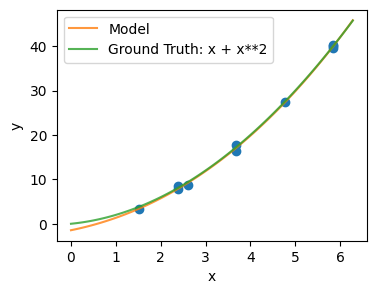

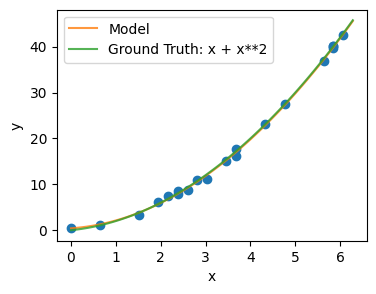

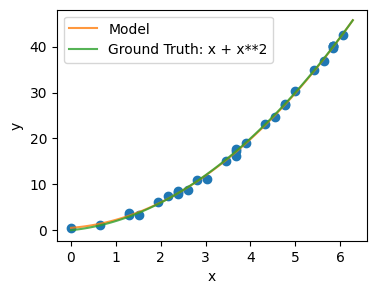

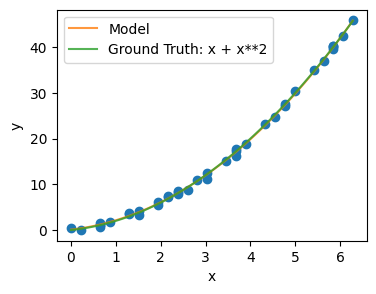

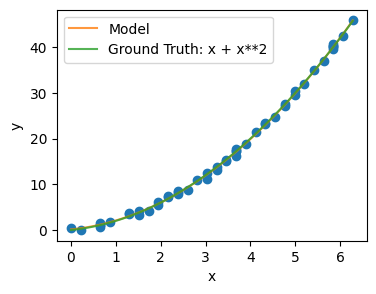


Updated State:
StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(0, 6.283185307179586), allowed_values=array([0.        , 0.21666156, 0.43332312, 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=          x
0  4.983216
1  5.849862
2  3.466585
3  4.116570
4  1.733292
5  3.249923
6  3.249923
7  5.199877
8  3.683247
9  4.333231, experiment_data=   

In [ ]:
#### First, let's reinitialize the state object to get a clean state ####
iv = Variable(name="x", value_range=(0, 2 * np.pi), allowed_values=np.linspace(0, 2 * np.pi, 30))
dv = Variable(name="y", type=ValueType.REAL)
variables = VariableCollection(independent_variables=[iv],dependent_variables=[dv])

conditions = random_pool(variables, num_samples=10, random_state=0)

s = StandardState(variables = variables, conditions = conditions, experiment_data = pd.DataFrame(columns=["x","y"]))

#Report previous state
print('\033[1mPrevious State:\033[0m')
print(s)

#Cycle
for cycle in range(5):
    s = custom_experimentalist(s, num_samples=10, random_state=42+cycle)
    s = custom_experiment_runner(s, added_noise=0.5, random_state=42+cycle)
    s = custom_theorist(s)
    
    plot_from_state(s, 'x + x**2')

#Report updated state
print('\n\033[1mUpdated State:\033[0m')
print(s)

Let's run the controller with the new theorist for 3 research cycles, defined by the number of models generated.

# Help
We hope that this tutorial helped demonstrate the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments. We encourage you to explore other [tutorials](https://autoresearch.github.io/autora/tutorials/) and check out the [documentation](https://autoresearch.github.io/).

If you encounter any issues, bugs, or questions, please reach out to us through the [AutoRA Forum](https://github.com/orgs/AutoResearch/discussions). Feel free to report any bugs by [creating an issue in the AutoRA repository](https://github.com/AutoResearch/autora/issues).

You may also post questions directly into the [User Q&A Section](https://github.com/orgs/AutoResearch/discussions/categories/using-autora).
